In [1]:
from typing import List, Dict
import math
import os
import pickle

import casadi as cas
import numpy as np
from scipy import signal
from dataclasses import dataclass
import matplotlib.pyplot as plt

from IOData.IOData import IOData, InputRule
from System.ErrorKinematicAcceLATI import LinearizedErrorKinematicAcceModel, LinearizedErrorKinematicAcceModelParams, KinematicAcceModelParams
from tools.simualtion_results import Results, PlotStyle

In [2]:
from System.DynamicModel import DynamicModel, DynamicModelParams

In [3]:
params = DynamicModelParams(
    Ts = 0.01,
    l_f = 0.052,
    l_r = 0.038,
    m = 0.181,
    Iz = 0.000505,
    Df = 0.65,
    Cf = 1.5,
    Bf = 5.2,
    Dr = 1.0,
    Cr = 1.45,
    Br = 8.5,
    Cm1 = 0.98028992,
    Cm2 = 0.01814131,
    Cd = 0.02750696,
    Croll = 0.08518052,
)

initial_state = np.array([0,0,0,0,0,0])


In [4]:
dynamic_model = DynamicModel(params, initial_state)
input = np.array([2, 0])

N = 10/0.01

states = []

for i in range(int(N)):
    if i<N/3:
        input = np.array([1, 0.1])
    elif i<N*2/3:
        input = np.array([1, 0.2])
    else:
        input = np.array([1, -0.2])
    states.append(dynamic_model.step(input))

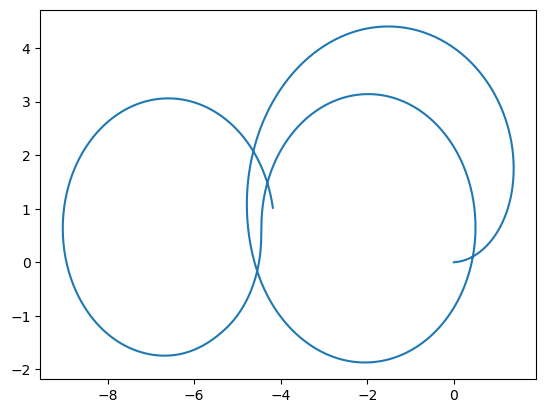

In [5]:
plt.plot([state[0] for state in states], [state[1] for state in states])

In [6]:
from System.DynamicErrorModel import DynamicErrorModelParams, DynamicErrorModel

In [7]:
dynamic_error_model_params = DynamicErrorModelParams(params, 1/0.3, np.array([0,0,0]), 1)
dynamic_error_model = DynamicErrorModel(dynamic_error_model_params, np.array([0,0,0,0,0,0]))

In [8]:
zero_input, zero_state = dynamic_error_model.calculate_zero_input_state()
print(zero_input)
print(zero_state)
dynamic_error_model.set_error_state(zero_state)
print(dynamic_error_model.dynamic_model.state)
for _ in range(100):
    dynamic_error_model.step(zero_input)
print(dynamic_error_model.state)

[0.14429742 0.32178485]
[ 0.         -0.09731416  1.          0.09762252  3.34917926  0.        ]
[ 1.83697020e-17  0.00000000e+00 -9.73141613e-02  1.00000000e+00
  9.76225193e-02  3.34917926e+00]
[-4.09749117e-13 -9.73141613e-02  1.00000000e+00  9.76225193e-02
  3.34917926e+00  1.00475378e+00]


In [9]:
dynamic_error_model.set_kinematic_model_state(np.array([0.3,0,0,0,0,0]))
print(dynamic_error_model.state)

[-0.12426407 -0.78539816  0.          0.          0.          0.23561945]


In [10]:
J_c = cas.jacobian(dynamic_error_model._f_c_r, dynamic_error_model._z_r)
J_c_fun = cas.Function('J_c_fun', [dynamic_error_model._z_r, dynamic_error_model._u], [J_c])
J_u = cas.jacobian(dynamic_error_model._f_c_r, dynamic_error_model._u)
J_u_fun = cas.Function('J_u_fun', [dynamic_error_model._z_r, dynamic_error_model._u], [J_u])

J_g = cas.jacobian(dynamic_error_model._g, dynamic_error_model._z_r)
J_g_fun = cas.Function('J_g_fun', [dynamic_error_model._z_r], [J_g])

A = J_c_fun(dynamic_error_model.get_zero_state(), dynamic_error_model.get_zero_input())
C = J_g_fun(dynamic_error_model.get_zero_state())

print(A)
print(C)

A = A[:5,:5]
C = C[:,:-1]

M = C
Phi = C
for i in range(1,5):
    M = M@A
    Phi = cas.vertcat(Phi, M)
Phi = np.array(Phi)
np.linalg.matrix_rank(Phi)
S, V, D = np.linalg.svd(Phi)
print(V)


[[00, 1.00475, -0.0971606, 0.995269, 00, 00], 
 [-11.1639, -1.15648e-15, -3.31756, -0.323869, 1, 00], 
 [00, 00, -2.19655, 10.2597, 0.45697, 00], 
 [00, 00, 0.508141, -80.6509, 0.199108, 00], 
 [00, 00, 129.195, 429.779, -51.1025, 00], 
 [3.34918, 3.46945e-16, 0.995269, 0.0971606, 00, 00]]

[[1, 00, 00, 00, 00, 00], 
 [00, 1, 00, 00, 00, 00], 
 [00, 00, 1, 00, 00, 00], 
 [00, 00, 00, 1, 00, 00]]
[4.54015713e+07 4.08315897e+05 1.78215931e+02 5.73041984e+01
 5.58609857e-01]
